In [1]:
# Import packages
import pandas as pd
from datetime import datetime
from datetime import date
import xlrd
import numpy as np
import re
# Some functions built by the user
import myfunction as mf
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enterprise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Import dataset - collected in part 1
df_row = pd.read_csv("Amazon_data")
print(df_row.shape)
df_row.head(2)

(560, 3)


,Unnamed: 0,headline,date
0,0,Suing Google Won’t Help Consumers,2020-10-20
1,1,"What to Watch: A Cartoonist Gets ‘Woke,’ ‘Coas...",2020-09-10


In [38]:
df_row.tail()

,Unnamed: 0,headline,date
555,555,Amazon’s Cloud Cover Makes It a Bigger Threat,2016-05-20
556,556,Gap Open to Selling on Amazon,2016-05-18
557,557,"Amazon Plans More Stores, Bulked-Up Prime Serv...",2016-05-17
558,558,Amazon Expands Restaurant Delivery to New York...,2016-05-17
559,559,Amazon Launches YouTube-Like Video Service,2016-05-10


In [6]:
# Get dates and convert them from excel to python dates
excel_dates = np.asarray(df_row["date"])
python_date = []
for j in range(len(excel_dates)):
    python_date.append(date(int(excel_dates[j][:4]),int(excel_dates[j][5:7]),int(excel_dates[j][8:10])))
# Reset index to converted dates
df_row["Dates"] = python_date
df_row = df_row.set_index('Dates')
df_row = df_row.drop(["date"], axis = 1)
df_row.head(2)

,Unnamed: 0,headline
Dates,,
2020-10-20,0,Suing Google Won’t Help Consumers
2020-09-10,1,"What to Watch: A Cartoonist Gets ‘Woke,’ ‘Coas..."


In [7]:
df = df_row#.reset_index(drop=True)
del df['Unnamed: 0']
df.head()

,headline
Dates,
2020-10-20,Suing Google Won’t Help Consumers
2020-09-10,"What to Watch: A Cartoonist Gets ‘Woke,’ ‘Coas..."
2020-09-02,"What to Watch: With ‘Cobra Kai,’ a Middle-Aged..."
2020-08-09,That Shooting Star You See in the Sky May Well...
2020-06-09,How Tim Gunn Made It Work


In [135]:
# Create a monthly document based on time etherogenous frequencies headlines
months = []
for t in range(len(python_date)):
    months.append(python_date[t].month)
df = pd.DataFrame()
df["months"] = months
df["document"] = ""
df["Dates"] = python_date
df["Dates"] = df["Dates"] - pd.tseries.offsets.MonthEnd()
# Add the monthly index to the original data
df_row["months"] = months
# merging "daily" headlines into a monthly document
for m in np.unique(months):
    this_month_document = df_row["headline"][df_row["months"]==m]
    df["document"][df["months"]==m] = ' '.join(this_month_document)
df = df.set_index('Dates')
df = df.drop(["months"], axis = 1)
df.drop_duplicates(inplace = True)
df

,document
Dates,
2020-09-30,Suing Google Won’t Help Consumers Where Tech T...
2020-08-31,"What to Watch: A Cartoonist Gets ‘Woke,’ ‘Coas..."
2020-07-31,That Shooting Star You See in the Sky May Well...
2020-05-31,How Tim Gunn Made It Work How Tim Gunn Made It...
2020-04-30,On Amazon’s ‘Making the Cut’ Fashion Is a Tota...
2020-03-31,Amazon Aims to Test All Employees for Covid-19...
2020-01-31,"‘Hunters’ Mixes Nazis, Heroes, Al Pacino to Ex..."
2019-12-31,How Amazon Puts Consumers at Risk How Amazon P...
2019-11-30,One Independent Movie Theater Struggles to Sur...


## Clean text from punctuation and convert to lower case

In [8]:
documents = df["headline"]
for i in range(len(documents)):
    # convert to lower case
    documents[i] = documents[i].lower()
    # take out non words
    documents[i] = re.sub(r'\W',' ',documents[i])
    # drop multiple spaces
    documents[i] = re.sub(r'\s+',' ',documents[i])

## Remove stopwords (words that do not add any value) and empty

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')).union([""])
import copy
filtered_documents = copy.deepcopy(documents)
for j in range(len(documents)):
    filtered_documents[j] = [w for w in documents[j].split(" ") if not w in stop_words]

#### Split documents into words-components and put them into a list + create a set with all the words (non duplicates)

In [10]:
list_documents = []
total = []
for j in range(len(filtered_documents)):
    this_document = filtered_documents[j]
    list_documents.append(this_document)
    total = set(total).union(set(this_document))

## Count words in each sentence

In [11]:
wordDict = []
# Create a dictionary with all words
Doc_count_word = dict.fromkeys(total, 0)
for j in range(len(filtered_documents)):
    this_wordDict = dict.fromkeys(total, 0) 
    #print(this_wordDict)
    for word in filtered_documents[j]:
        #print(word)
        #print(this_wordDict[word])
        # count how many documents contain the word
        if this_wordDict[word] == 0 : Doc_count_word[word] += 1
        #print(word)
        # plus count how many times the word is contained into the document
        this_wordDict[word] += 1
        #print(this_wordDict[word])
    wordDict.append(this_wordDict) 

## compute the term frequency (n times words / total words)

In [12]:
# https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/
tfAll = []
for j in range(len(wordDict)):
    tfAll.append(mf.computeTF(wordDict[j], list_documents[j]))

## Compute Inverse Data Frequency (idf)

In [13]:
#log10(number of documents on / number of documents containing the word)

idfs = mf.computeIDF(Doc_count_word, len(wordDict))
# Compute TFidf
TFidf = []
for j in range(len(wordDict)):
    TFidf.append(mf.computeTFIDF(tfAll[j], idfs))
df_TFidf = pd.DataFrame(TFidf)

## Import dictionaries (words)

In [14]:
# see link if you'd like to know about GI and LM words.
# https://cran.r-project.org/web/packages/SentimentAnalysis/SentimentAnalysis.pdf
positives_all = list(pd.read_csv("Positive.csv")["both"].dropna())
negatives_all = list(pd.read_csv("Negative.csv")["both"].dropna())
positives_LM = list(pd.read_csv("Positive.csv")["LM"].dropna())
negatives_LM = list(pd.read_csv("Negative.csv")["LM"].dropna())
positives_GI = list(pd.read_csv("Positive.csv")["GI"].dropna())
negatives_GI = list(pd.read_csv("Negative.csv")["GI"].dropna())

## Map words to numbers using the three dictionaries

In [15]:
Doc_word_LM = mf.map_word_to_sent(Doc_count_word, positives_LM, negatives_LM, similarity_check = False)
Doc_word_GI = mf.map_word_to_sent(Doc_count_word, positives_GI, negatives_GI, similarity_check = False)
Doc_word_all = mf.map_word_to_sent(Doc_count_word, positives_all, negatives_all, similarity_check = True)

## Compute scores by weighting the words by the weights obtaining using TFidf

In [16]:
df_scores_GI = copy.deepcopy(df_TFidf)
df_scores_LM = copy.deepcopy(df_TFidf)
df_scores_all = copy.deepcopy(df_TFidf)
for this_key in df_scores_all.keys():
    df_scores_GI[this_key] = df_scores_GI[this_key]*Doc_word_GI[this_key]
    df_scores_LM[this_key] = df_scores_LM[this_key]*Doc_word_LM[this_key]
    df_scores_all[this_key] = df_scores_all[this_key]*Doc_word_all[this_key]

## Put in a unique dataframe

In [17]:
final_df = pd.DataFrame()
final_df["sentiment_index_GI"] = df_scores_GI.sum(axis = 1)
final_df["sentiment_index_LM"] = df_scores_LM.sum(axis = 1)
final_df["sentiment_index_all"] = df_scores_all.sum(axis = 1)
final_df["Dates"] = df.index
final_df = final_df.set_index('Dates')


## Get week numbers and date entries by weeks

In [18]:
weeks = [i.isocalendar()[1] for i in python_date]
#months = [i.month for i in python_date]
final_df['week'] = weeks
#final_df['month'] = months
final_df['year'] = [python_date[i].year for i in range(len(python_date))]; final_df.head()
final_df = final_df.groupby(['year', 'week']).mean().reset_index()
#final_df = final_df.groupby(['year', 'month']).mean().reset_index()

final_df['Dates'] = final_df['year'].astype(str) + " " + final_df['week'].astype(str)
final_df['Dates'] = [datetime.strptime(i + ' 0', "%Y %W %w") for i in final_df['Dates']]
final_df.index = final_df['Dates'].reset_index(drop=True)
final_df.head()

,year,week,sentiment_index_GI,sentiment_index_LM,sentiment_index_all,Dates
Dates,,,,,,
2016-05-15,2016,19,0.000000,0.000000,-0.782503,2016-05-15
2016-05-22,2016,20,-0.013991,-0.082085,0.057780,2016-05-22
2016-06-05,2016,22,0.000000,0.000000,0.613475,2016-06-05
2016-06-12,2016,23,0.000000,0.000000,0.142634,2016-06-12
2016-06-19,2016,24,0.000000,0.000000,0.077613,2016-06-19


In [20]:
final_df['Dates'] = final_df['year'].astype(str) + " " + final_df['week'].astype(str)
final_df['Dates'] = [datetime.strptime(i + ' 0', "%Y %W %w") for i in final_df['Dates']]
final_df.index = final_df['Dates'].reset_index(drop=True)
final_df.head()

,year,week,sentiment_index_GI,sentiment_index_LM,sentiment_index_all,Dates
Dates,,,,,,
2016-05-15,2016,19,0.000000,0.000000,-0.782503,2016-05-15
2016-05-22,2016,20,-0.013991,-0.082085,0.057780,2016-05-22
2016-06-05,2016,22,0.000000,0.000000,0.613475,2016-06-05
2016-06-12,2016,23,0.000000,0.000000,0.142634,2016-06-12
2016-06-19,2016,24,0.000000,0.000000,0.077613,2016-06-19


## SP500 and Amazon

In [21]:
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2016,5,1)
end = dt.datetime(2021,1, 1)
amazon = web.get_data_yahoo('amzn', start, end, interval='w')['Adj Close']
spx = web.get_data_yahoo('spy', start, end, interval='w')['Adj Close']

amazonR = np.log(amazon) - np.log(amazon.shift(1))
spxR = np.log(spx) - np.log(spx.shift(1))

In [22]:
exReturns = (amazonR-spxR)
exReturns = pd.DataFrame(amazonR-spxR)
exReturns.columns = ['eRets']
exReturns = exReturns.iloc[1: , :]

exReturns['week'] = [i.isocalendar()[1] for i in exReturns.index]
#exReturns['month'] = [i.isocalendar()[1] for i in exReturns.index]
exReturns['year'] = [i.year for i in exReturns.index]
exReturns['Dates'] = exReturns['year'].astype(str) + " " + exReturns['week'].astype(str)
exReturns['Dates'] = [datetime.strptime(i + ' 0', "%Y %W %w") for i in exReturns['Dates']]

In [27]:
data = final_df.merge(exReturns, on=['week', 'year'])

print(np.cov(data.sentiment_index_all, data.eRets))
data.head()

[[2.51861615e-01 1.77257865e-05]
 [1.77257865e-05 7.61283763e-04]]


,year,week,sentiment_index_GI,sentiment_index_LM,sentiment_index_all,Dates_x,eRets,Dates_y
0,2016,19,0.000000,0.000000,-0.782503,2016-05-15,0.056674,2016-05-15
1,2016,20,-0.013991,-0.082085,0.057780,2016-05-22,-0.013639,2016-05-22
2,2016,22,0.000000,0.000000,0.613475,2016-06-05,0.018311,2016-06-05
3,2016,23,0.000000,0.000000,0.142634,2016-06-12,-0.009573,2016-06-12
4,2016,24,0.000000,0.000000,0.077613,2016-06-19,0.000867,2016-06-19


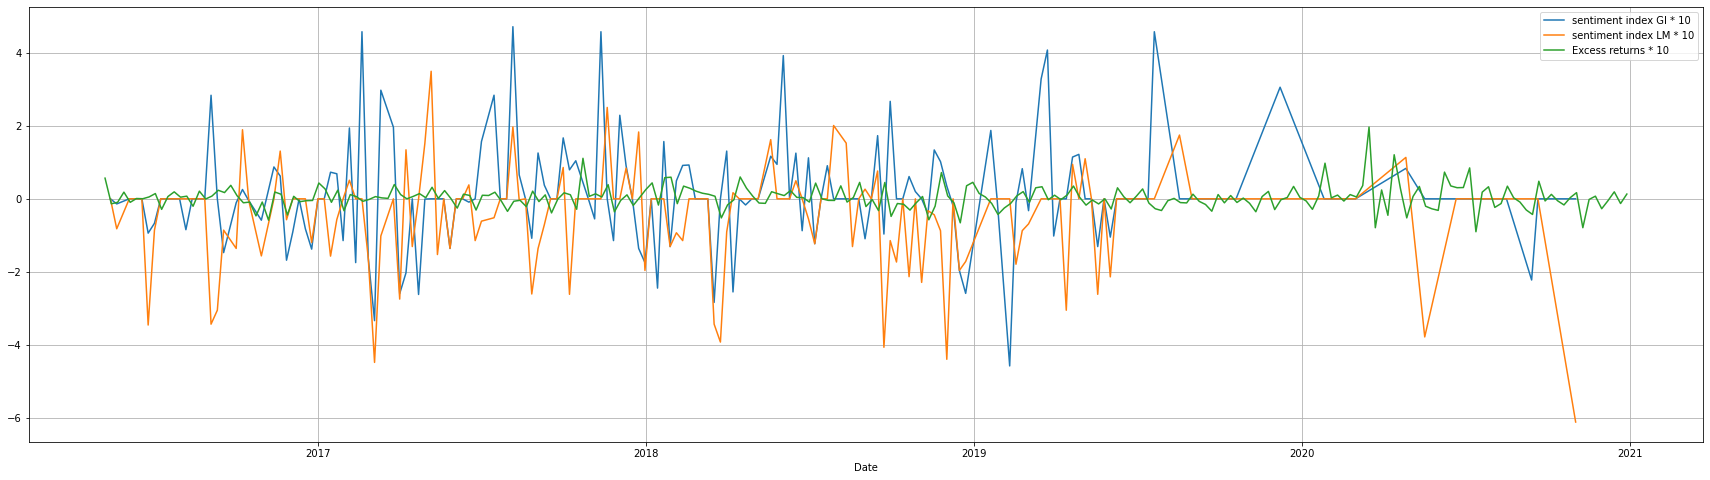

In [34]:
# Plot all of them - if plot does not show, just run this block a second time
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(final_df["sentiment_index_GI"]*10, label = "sentiment index GI * 10")
ax.plot(final_df["sentiment_index_LM"]*10, label = "sentiment index LM * 10")
#ax.plot(final_df["sentiment_index_all"]*10, label = "sentiment index all * 10")
ax.plot(exReturns.eRets*10, label = "Excess returns * 10",)
ax.set_xlabel('Date')
ax.legend()
ax.grid()
plt.show()

# FinBERT

In [4]:
# FinBERT is a pre-trained NLP model to analyze sentiment of financial text. 
# It is built by further training the BERT language model in the finance domain, 
# using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

# What data was FinBERT trained on? 

# The data used to train FibBERT is text from financial news services, 
# as well as the FiQA dataset. 
# https://sites.google.com/view/fiqa/

# For the financial news:
# e.g.
# "the annotators were asked to give labels according to how they think the information 
# in the sentence might affect the mentioned company stock price."

# In other words, sentiment here is more-or-less a proxy for how people felt certain news and information would affect a company's price. 
# Negative sentiment would lead to a stock losing value while positive sentiment would of course result in this guy:

In [5]:
# We quickly noticed that naive approaches such as bag-of-words would simply not cut it, 
# as they generally disregard essential context information in the text. 
# We needed more advanced techniques to crack the financial context and understand 
# what is positive and what is negative from the financial point of view.

# We'll read the .csv file with Pandas Python library and print a little snippet.

# Please run this part under the Pytorch environment

import pandas

headlines_df = pandas.read_csv('Amazon_data')
headlines_df.head(5)

,Unnamed: 0,headline,date
0,0,Suing Google Won’t Help Consumers,2020-10-20
1,1,"What to Watch: A Cartoonist Gets ‘Woke,’ ‘Coas...",2020-09-10
2,2,"What to Watch: With ‘Cobra Kai,’ a Middle-Aged...",2020-09-02
3,3,That Shooting Star You See in the Sky May Well...,2020-08-09
4,4,How Tim Gunn Made It Work,2020-06-09


In [6]:
# Then, we'll use NumPy to shuffle the entries and convert them to a normal Python list containing the headlines. 
# This list can be used as an input to the FinBERT model. 

import numpy as np

headlines_array = np.array(headlines_df)
np.random.shuffle(headlines_array)
headlines_list = list(headlines_array[:,1])

print(headlines_list)

['Amazon Cracks Down on Scams, Fires Employees Over Data Leak', 'Bezos Pledges $2 Billion for Charity', 'Amazon May Still See Benefits From Failed New York Courting Process', 'Big Tech’s Welcome Mat Is Fraying', 'Welcome to New York, Amazon—Now Go Home', 'After Amazon HQ2, Uproar in New York Over Real Estate ‘Insider Trading’', 'Amazon Picks New York City, Northern Virginia for Its HQ2 Locations', 'How One Bookstore Succeeds in the Amazon Age', 'Amazon Reports Third Record Profit in a Row', 'Big Tech’s Hot New Talent Incubator: Community College', 'Stop Bezos From Hiring Poor People?', 'Department-Store Woes Catch Up to Kohl’s', 'Competition for Tech Talent Is Tight', 'Amazon Slashed Prices at Whole Foods; Now They’re Going Up', 'How Tech is Drawing Shoppers Back to Bricks-and-Mortar Stores', 'The Score: The Business Week in 7 Stocks', '‘Marvelous Mrs. Maisel’ Readies Its Second Season', 'Why Amazon Needs to Do Everything', 'Amazon in Late-Stage Talks for HQ2 Location', 'Amazon HQ2 Run

In [7]:
# HuggingFace makes it really easy for us to try out different NLP models. 
# We can find the FinBERT model on the HuggingFace model hub 
# & even run a test inference using a little text box right on their website:

!git clone https://huggingface.co/ProsusAI/finbert

fatal: destination path 'finbert' already exists and is not an empty directory.


In [8]:
# We'll start off working with the NLP model by installing the HuggingFace transformers library. 

!pip install transformers

# Getting the tokenizer and the model

from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Then, from the HuggingFace Model Hub we'll download the pretrained tokenizer, 
# which is used to convert text into tokens that NLP models can understand. 
# We also load the pretrained model itself in a similar way. 

In [9]:
# So now we can take the Python list of the headlines we've preprocessed 
# (note: tokenizer accepts Python lists of strings as input), 
# and pass them through the tokenizer to preprocess them before being inputted into the model with the following lines of code.

# That's where the headlines get tokenized to be inputted into model

inputs = tokenizer(headlines_list, padding = True, truncation = True, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[  101,  9733, 15288,  ...,     0,     0,     0],
        [  101,  2022, 28370,  ...,     0,     0,     0],
        [  101,  9733,  2089,  ...,     0,     0,     0],
        ...,
        [  101,  2017,  2134,  ...,     0,     0,     0],
        [  101,  9733,  1521,  ...,     0,     0,     0],
        [  101, 24969,  1024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [11]:
# Inference

outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([180, 3])


In [12]:
# Next, all that's left is to postprocess the outputs with the softmax activation function. 
# It's useful because we can't have all of the three classes have the the value of one - the maximum value. 
# It would mean that a headline is extremely positive, negative and neutral - all at the same time. 

# This function makes it such that all of the scores for our classes 
# (e.g. positive, negative, neutral - in our case) add up to 1 
# and thus, can be interpreted as probabilities. Also, the larger input components will correspond to larger probabilities. 

# Postprocessing with softmax

import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.0081, 0.9571, 0.0347],
        [0.2775, 0.0093, 0.7132],
        [0.5364, 0.4176, 0.0459],
        [0.0448, 0.8152, 0.1400],
        [0.0484, 0.0284, 0.9232],
        [0.0189, 0.9129, 0.0682],
        [0.0648, 0.0112, 0.9241],
        [0.0730, 0.0172, 0.9098],
        [0.6702, 0.2593, 0.0705],
        [0.0931, 0.0198, 0.8871],
        [0.0421, 0.2845, 0.6733],
        [0.6365, 0.1189, 0.2447],
        [0.1744, 0.0294, 0.7962],
        [0.1196, 0.3928, 0.4877],
        [0.0931, 0.0264, 0.8805],
        [0.0290, 0.1457, 0.8253],
        [0.1815, 0.0366, 0.7819],
        [0.0461, 0.0243, 0.9296],
        [0.0509, 0.0144, 0.9347],
        [0.0159, 0.9444, 0.0397],
        [0.0126, 0.8771, 0.1102],
        [0.0625, 0.0360, 0.9014],
        [0.1177, 0.1666, 0.7156],
        [0.0149, 0.9519, 0.0332],
        [0.8510, 0.0086, 0.1405],
        [0.0280, 0.8607, 0.1113],
        [0.0290, 0.0869, 0.8841],
        [0.1235, 0.0162, 0.8603],
        [0.0307, 0.7357, 0.2336],
        [0.226

In [13]:
# Model classes

model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [14]:
# All we need to do is define a Pandas DataFrame with the four relevant to us columns
# (basically, defining a table in Python).

# Formatting the results as a pandas data frame

import pandas as pd

#Headline #Positive #Negative #Neutral
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Headline':headlines_list,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
      
df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])

df.head(5)

,Headline,Positive,Negative,Neutral
0,"Amazon Cracks Down on Scams, Fires Employees O...",0.008143,0.957139,0.034718
1,Bezos Pledges $2 Billion for Charity,0.277467,0.009340,0.713193
2,Amazon May Still See Benefits From Failed New ...,0.536448,0.417612,0.045940
3,Big Tech’s Welcome Mat Is Fraying,0.044774,0.815219,0.140007
4,"Welcome to New York, Amazon—Now Go Home",0.048438,0.028382,0.923180


In [ ]:
# You can try comparing with lexicon-based models and see what is the difference.